# Temporal Relationships Modelings ⌚️

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Load in cleaned dataset

In [157]:
base_path = Path.cwd().parent
meta_file_path = base_path / "data" / "california_clean_metadata.json.gz"
data_path = base_path / "data" / "california_clean_data.json.gz"

meta_df = pd.read_json(meta_file_path, compression = 'gzip', lines = True)
df = pd.read_json(data_path, compression = 'gzip', lines = True)
df = df.reset_index()

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158336 entries, 0 to 1158335
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   review_time(unix)   1158336 non-null  datetime64[ns]
 1   reviewer_id         1158336 non-null  float64       
 2   reviewer_name       1158336 non-null  object        
 3   rating              1158336 non-null  int64         
 4   text                650897 non-null   object        
 5   resp                73022 non-null    object        
 6   gmap_id             1158336 non-null  object        
 7   has_rep             1158336 non-null  bool          
 8   gmap_name           1158336 non-null  object        
 9   address             1158336 non-null  object        
 10  latitude            1158336 non-null  float64       
 11  longitude           1158336 non-null  float64       
 12  description         838359 non-null   object        
 13  category    

In [85]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gmap_id           15291 non-null  object 
 1   gmap_name         15291 non-null  object 
 2   address           15291 non-null  object 
 3   latitude          15291 non-null  float64
 4   longitude         15291 non-null  float64
 5   description       4478 non-null   object 
 6   category          15291 non-null  object 
 7   avg_rating        15291 non-null  float64
 8   num_of_reviews    15291 non-null  int64  
 9   price             3518 non-null   object 
 10  hours             12194 non-null  object 
 11  MISC              13207 non-null  object 
 12  relative_results  15291 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 1.5+ MB


Merging two df

In [1]:
merged_df = df.merge(meta_df, on='gmap_id', how='inner')
columns_to_remove = [col for col in df.columns if col.endswith('_y')]
merged_clean = df.drop(columns=columns_to_remove)
merged_clean.info()

NameError: name 'df' is not defined

## Rolling Means Windows

In [159]:
df['review_time(unix)'] = df['review_time(unix)'] / 1000
df['review_time(unix)'] = pd.to_datetime(df['review_time(unix)'], unit='s', errors='coerce')
df = df.sort_values('review_time(unix)')
df.set_index('review_time(unix)', inplace=True)

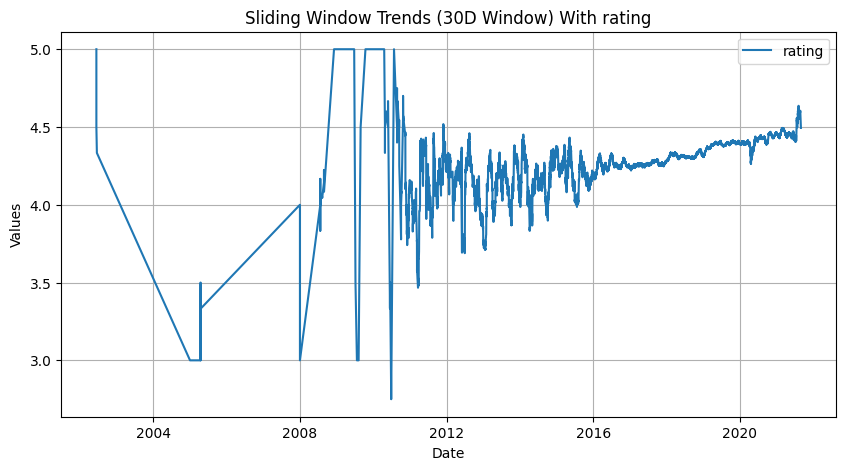

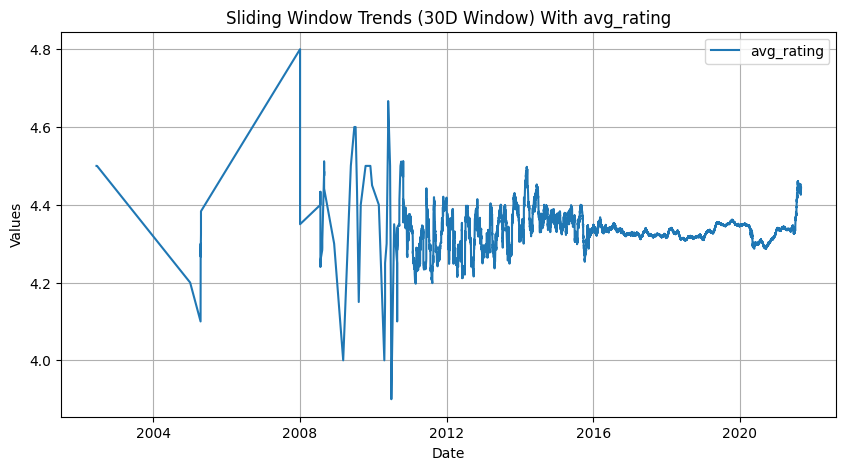

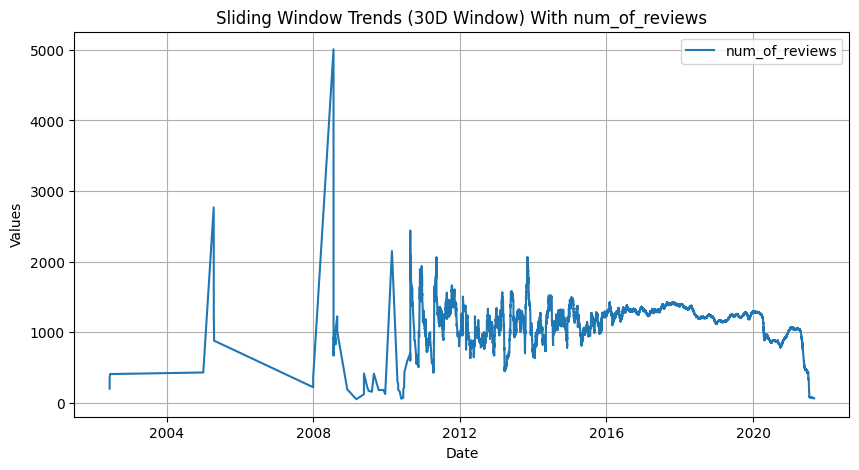

In [69]:
# Rolling means
columns_to_analyze = ['rating', 'avg_rating', 'num_of_reviews']
window_size = '30D'

rolling_stats = df[columns_to_analyze].rolling(window=window_size).mean()

for column in columns_to_analyze:
    plt.figure(figsize=(10, 5))
    plt.plot(rolling_stats.index, rolling_stats[column], label=column)
    plt.title(f"Sliding Window Trends ({window_size} Window) With {column}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.grid()
    plt.show()

# Temporal Heatmap

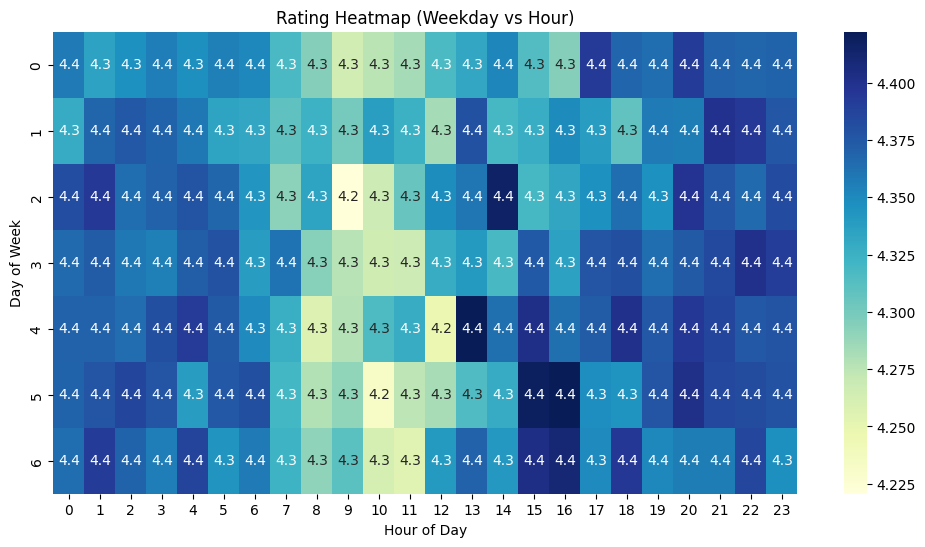

In [70]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

heatmap_data = df.pivot_table(index='weekday', columns='hour', values='rating', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Rating Heatmap (Weekday vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


# Temporal Anomaly Detection

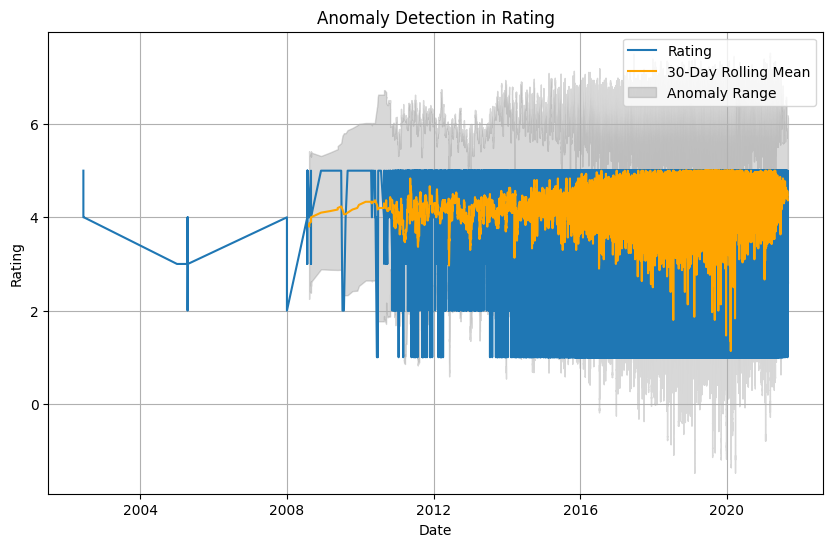

In [71]:
# Rolling mean and standard deviation
rolling_mean = df['rating'].rolling(window=30).mean()
rolling_std = df['rating'].rolling(window=30).std()

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['rating'], label='Rating')
plt.plot(df.index, rolling_mean, color='orange', label='30-Day Rolling Mean')
plt.fill_between(df.index, rolling_mean - 2 * rolling_std, rolling_mean + 2 * rolling_std, color='gray', alpha=0.3, label='Anomaly Range')
plt.legend()
plt.title('Anomaly Detection in Rating')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.grid()
plt.show()

# Moving Averages Across Time

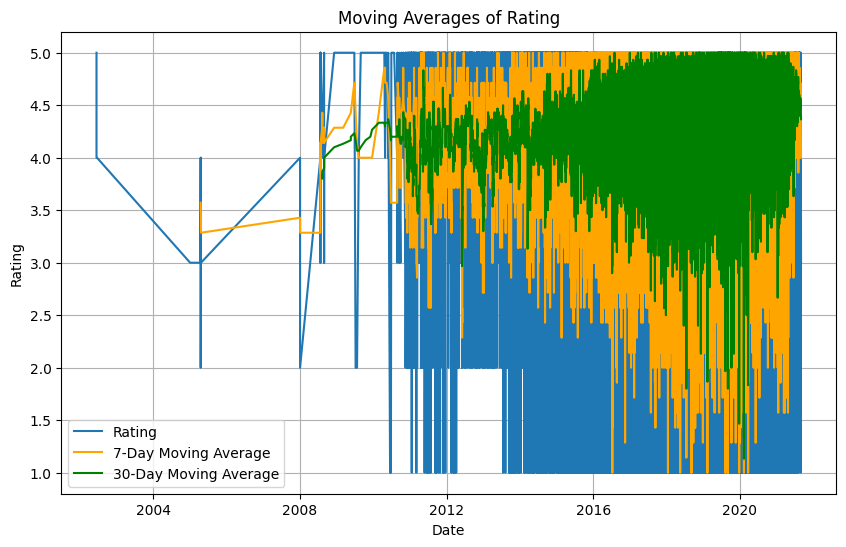

In [72]:
short_window = df['rating'].rolling(window=7).mean()
long_window = df['rating'].rolling(window=30).mean()

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['rating'], label='Rating')
plt.plot(df.index, short_window, label='7-Day Moving Average', color='orange')
plt.plot(df.index, long_window, label='30-Day Moving Average', color='green')
plt.legend()
plt.title('Moving Averages of Rating')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.grid()
plt.show()

# Rolling Correlation Between `avg_rating` and `num_of_reviews`

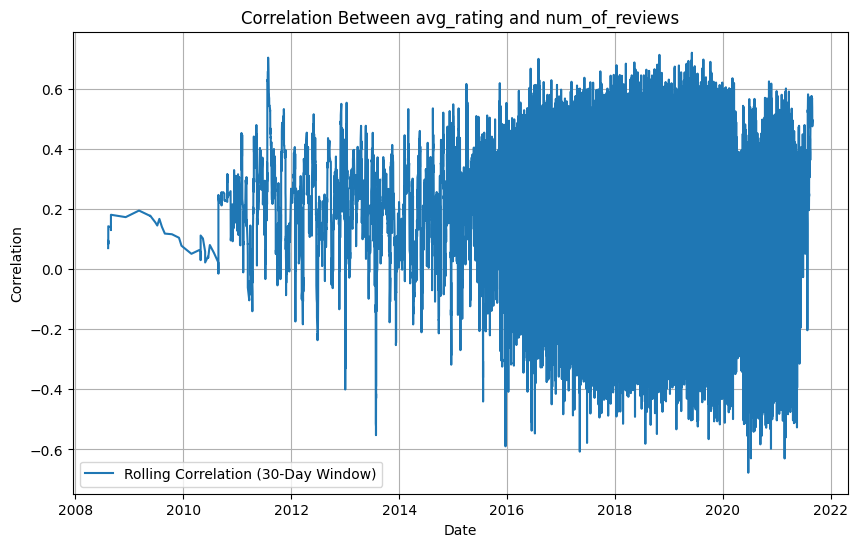

In [73]:
correlation = df['avg_rating'].rolling(window=30).corr(df['num_of_reviews'])

plt.figure(figsize=(10, 6))
plt.plot(correlation, label='Rolling Correlation (30-Day Window)')
plt.title('Correlation Between avg_rating and num_of_reviews')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid()
plt.show()

# Temporal Clusters
Based on the `time feature` (all numerical columns available), form different clusters using KMeans, then observe trends of these clusters.
- `df.resample('M').mean()` group data by Month and averages data based on so.
- Unit of opertaion is based on month now, so seeing how all the numerical data would interact based on month
- **Result represent that we are grouping a few different rows or months together, showing that there is a numerical similarity in the features (`rating`, `num_reviews`)**

In [206]:
NUM_CLUSTER = 3
time_features = df.resample('M').mean()
time_features.fillna(time_features.mean(), inplace=True)
time_features_normalized = (time_features - time_features.mean()) / time_features.std()
time_features_normalized.drop(columns=['index', 'reviewer_id', 'has_rep', 'latitude', 'longitude', 'avg_rating'])

,rating,num_of_reviews
review_time(unix),,
2002-06-30,0.313187,-2.022743
2002-07-31,0.000000,0.000000
2002-08-31,0.000000,0.000000
2002-09-30,0.000000,0.000000
2002-10-31,0.000000,0.000000
...,...,...
2021-05-31,0.660037,-1.762662
2021-06-30,0.614226,-1.943134
2021-07-31,1.085168,-3.067855


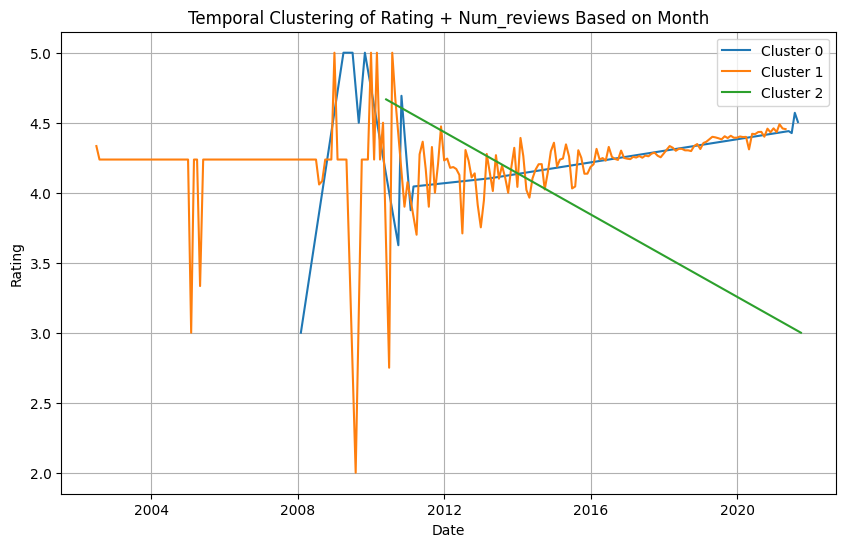

In [207]:
kmeans = KMeans(n_clusters=NUM_CLUSTER)
time_features['cluster'] = kmeans.fit_predict(time_features_normalized)

plt.figure(figsize=(10, 6))
for cluster in range(NUM_CLUSTER):
    cluster_data = time_features[time_features['cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data['rating'], label=f'Cluster {cluster}')

plt.legend()
plt.title('Temporal Clustering of Rating + Num_reviews Based on Month')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.grid()
plt.show()

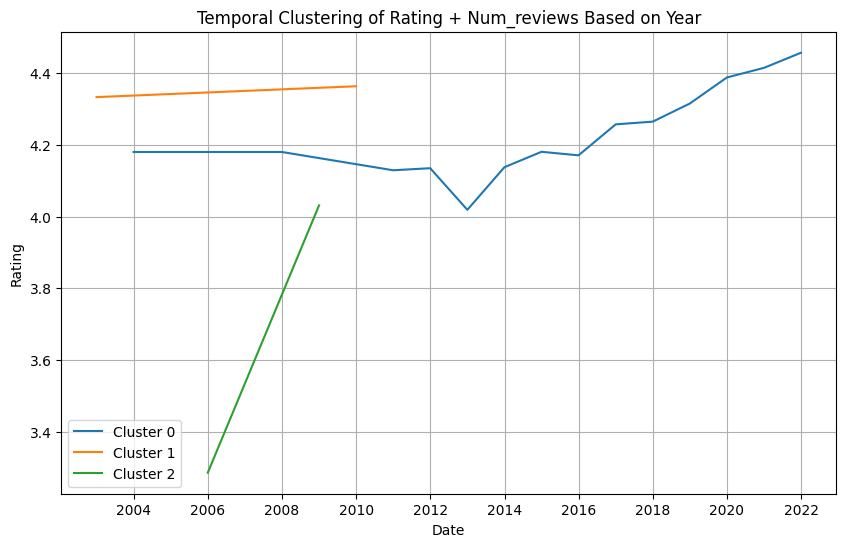

In [209]:
NUM_CLUSTER = 3
time_features = df.resample('Y').mean()
time_features.fillna(time_features.mean(), inplace=True)
time_features_normalized = (time_features - time_features.mean()) / time_features.std()
time_features_normalized.drop(columns=['index', 'reviewer_id', 'has_rep', 'latitude', 'longitude', 'avg_rating'])

kmeans = KMeans(n_clusters=NUM_CLUSTER)
time_features['cluster'] = kmeans.fit_predict(time_features_normalized)

plt.figure(figsize=(10, 6))
for cluster in range(NUM_CLUSTER):
    cluster_data = time_features[time_features['cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data['rating'], label=f'Cluster {cluster}')

plt.legend()
plt.title('Temporal Clustering of Rating + Num_reviews Based on Year')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.grid()
plt.show()

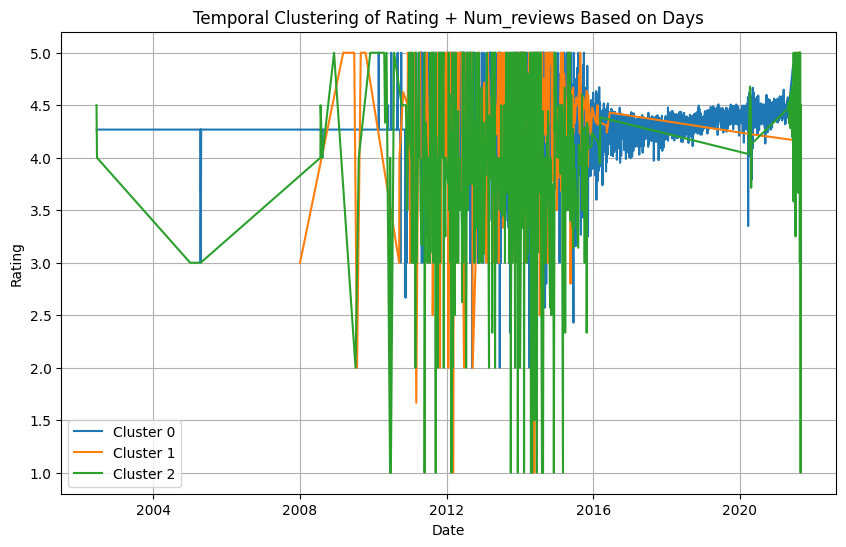

In [210]:
NUM_CLUSTER = 3
time_features = df.resample('D').mean()
time_features.fillna(time_features.mean(), inplace=True)
time_features_normalized = (time_features - time_features.mean()) / time_features.std()
time_features_normalized.drop(columns=['index', 'reviewer_id', 'has_rep', 'latitude', 'longitude', 'avg_rating'])

kmeans = KMeans(n_clusters=NUM_CLUSTER)
time_features['cluster'] = kmeans.fit_predict(time_features_normalized)

plt.figure(figsize=(10, 6))
for cluster in range(NUM_CLUSTER):
    cluster_data = time_features[time_features['cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data['rating'], label=f'Cluster {cluster}')

plt.legend()
plt.title('Temporal Clustering of Rating + Num_reviews Based on Days')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.grid()
plt.show()

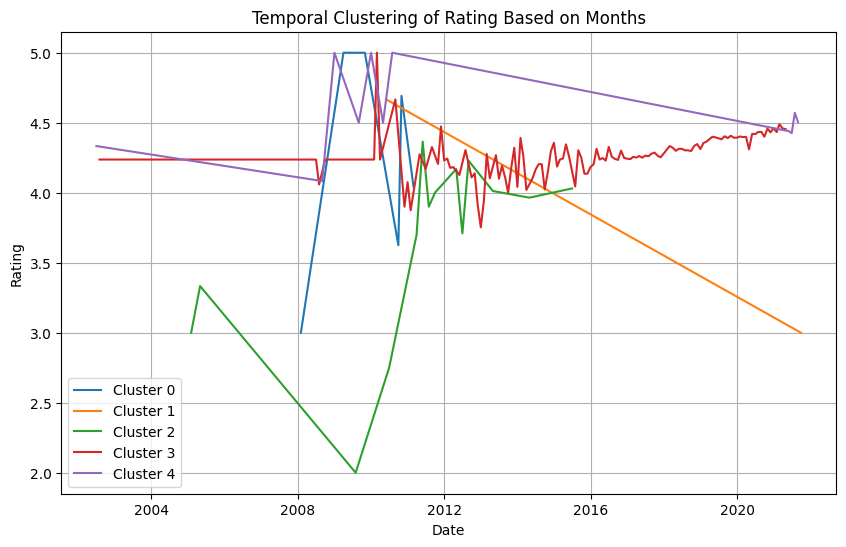

In [228]:
NUM_CLUSTER = 5
time_features = df.resample('M').mean()
time_features.fillna(time_features.mean(), inplace=True)
time_features_normalized = (time_features - time_features.mean()) / time_features.std()
time_features_normalized.drop(columns=['index', 'reviewer_id', 'has_rep', 'latitude', 'longitude', 'avg_rating', 'num_of_reviews'])

kmeans = KMeans(n_clusters=NUM_CLUSTER)
time_features['cluster'] = kmeans.fit_predict(time_features_normalized)

plt.figure(figsize=(10, 6))
for cluster in range(NUM_CLUSTER):
    cluster_data = time_features[time_features['cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data['rating'], label=f'Cluster {cluster}')

plt.legend()
plt.title('Temporal Clustering of Rating Based on Months')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.grid()
plt.show()

# Temporal Popularity Changes in Category and Hours

Group by year and category for rating sum

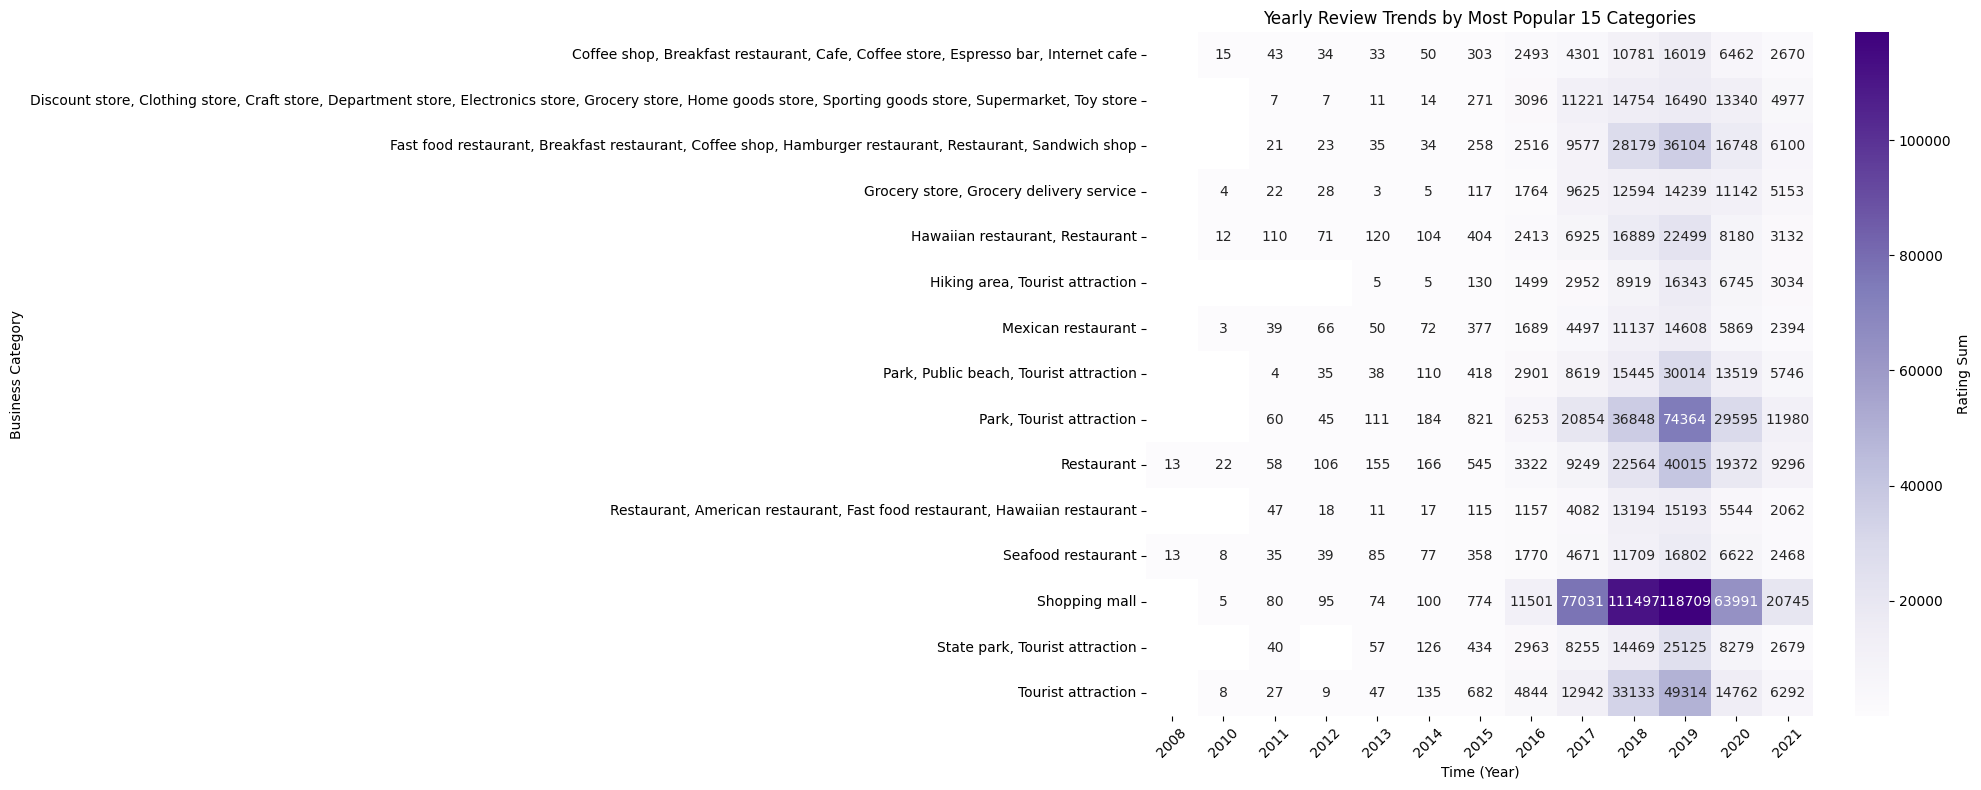

In [123]:
NUM_POP = 15
merged_clean['category'] = merged_clean['category'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

popular_categories = merged_clean.groupby('category')['rating'].sum().sort_values(ascending=False).head(NUM_POP).index
filtered_df = merged_clean[merged_clean['category'].isin(popular_categories)]

review_trends_popular = filtered_df.groupby([filtered_df['review_time(unix)'].dt.to_period('Y'), 'category'])['rating'].sum().unstack()

plt.figure(figsize=(20, 8))
sns.heatmap(review_trends_popular.T, cmap="Purples", annot=True, fmt="g", cbar_kws={'label': 'Rating Sum'})
plt.title(f'Yearly Review Trends by Most Popular {NUM_POP} Categories')
plt.xlabel('Time (Year)')
plt.ylabel('Business Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

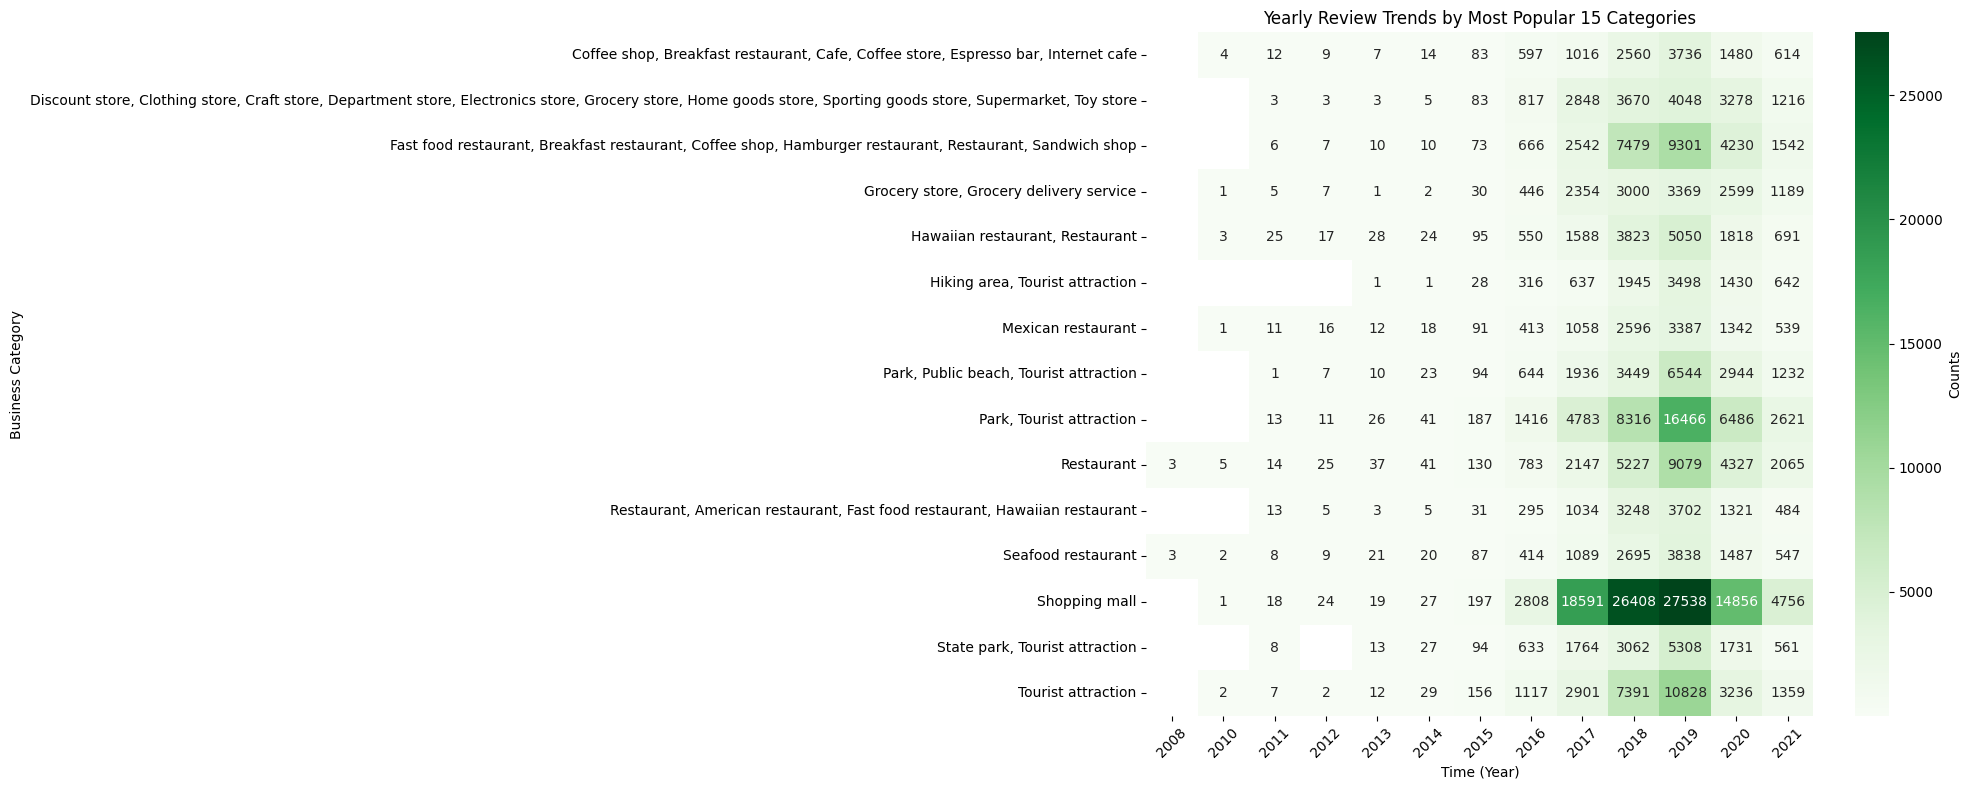

In [146]:
NUM_POP = 15
merged_clean['category'] = merged_clean['category'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

popular_categories = merged_clean.groupby('category')['rating'].sum().sort_values(ascending=False).head(NUM_POP).index
filtered_df = merged_clean[merged_clean['category'].isin(popular_categories)]

review_trends_popular = filtered_df.groupby([filtered_df['review_time(unix)'].dt.to_period('Y'), 'category'])['rating'].count().unstack()

plt.figure(figsize=(20, 8))
sns.heatmap(review_trends_popular.T, cmap="Greens", annot=True, fmt="g", cbar_kws={'label': 'Counts'})
plt.title(f'Yearly Review Trends by Most Popular {NUM_POP} Categories')
plt.xlabel('Time (Year)')
plt.ylabel('Business Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [139]:
merged_clean.hours.iloc[0]

[['Tuesday', '5:30–8:30PM'],
 ['Wednesday', '5:30–8:30PM'],
 ['Thursday', '5:30–8:30PM'],
 ['Friday', '5:30–8:30PM'],
 ['Saturday', '5:30–8:30PM'],
 ['Sunday', '9AM–1PM'],
 ['Monday', 'Closed']]

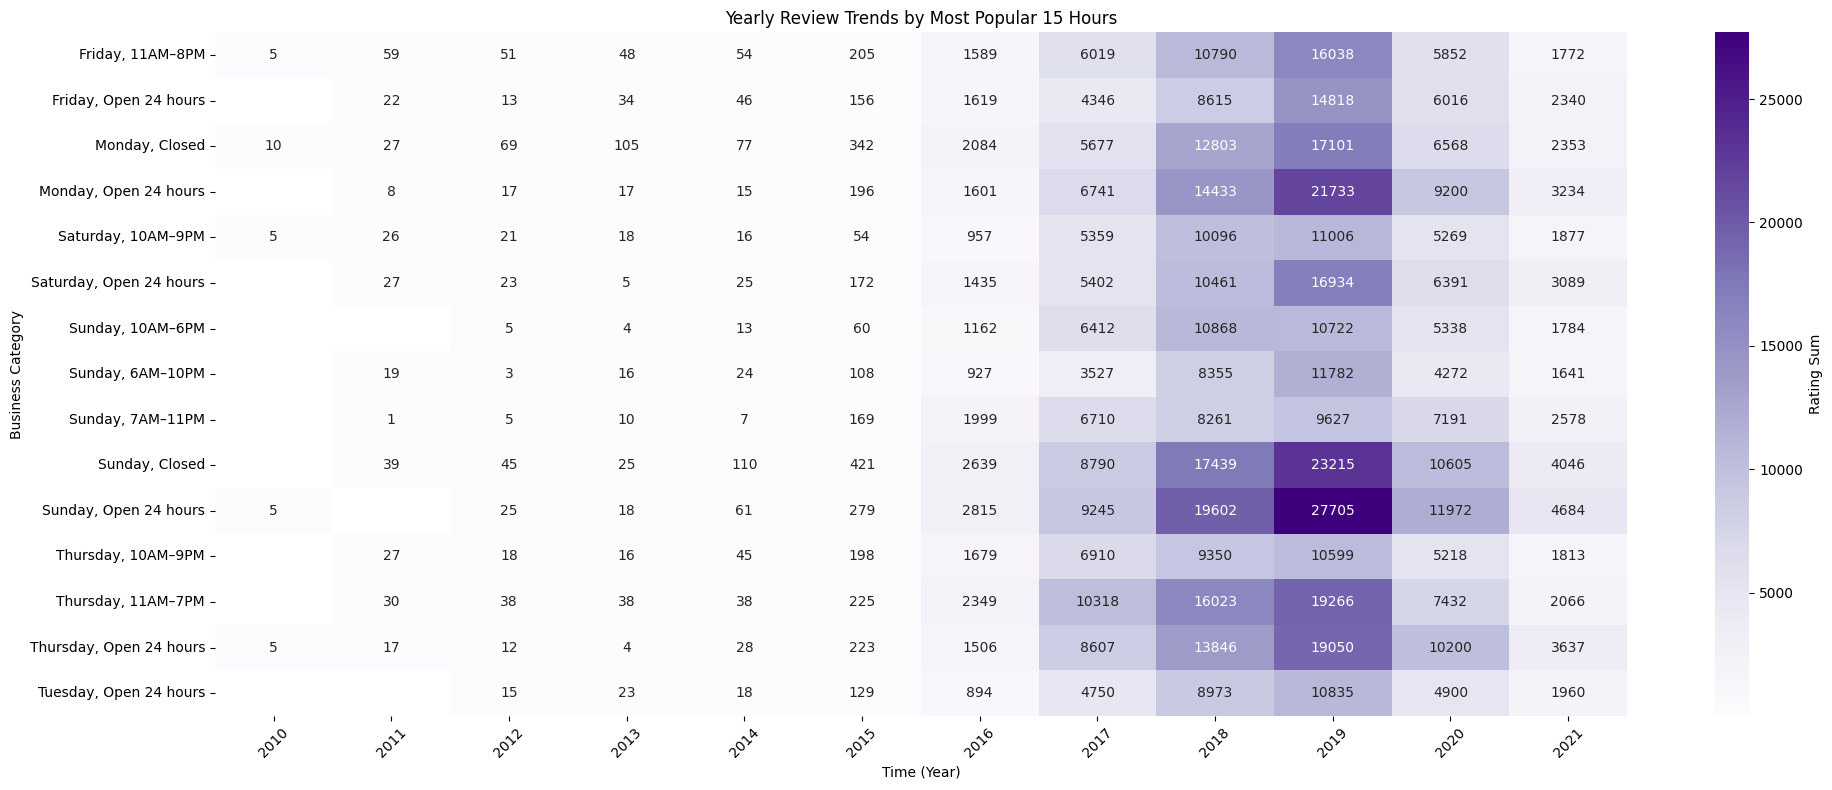

In [143]:
NUM_POP = 15
merged_clean['hours'] = merged_clean['hours'].apply(lambda x: ', '.join(x[0]) if isinstance(x, list) else x)

popular_categories = merged_clean.groupby('hours')['rating'].sum().sort_values(ascending=False).head(NUM_POP).index
filtered_df = merged_clean[merged_clean['hours'].isin(popular_categories)]

review_trends_popular = filtered_df.groupby([filtered_df['review_time(unix)'].dt.to_period('Y'), 'hours'])['rating'].sum().unstack()

plt.figure(figsize=(20, 8))
sns.heatmap(review_trends_popular.T, cmap="Purples", annot=True, fmt="g", cbar_kws={'label': 'Rating Sum'})
plt.title(f'Yearly Review Trends by Most Popular {NUM_POP} Hours')
plt.xlabel('Time (Year)')
plt.ylabel('Business Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

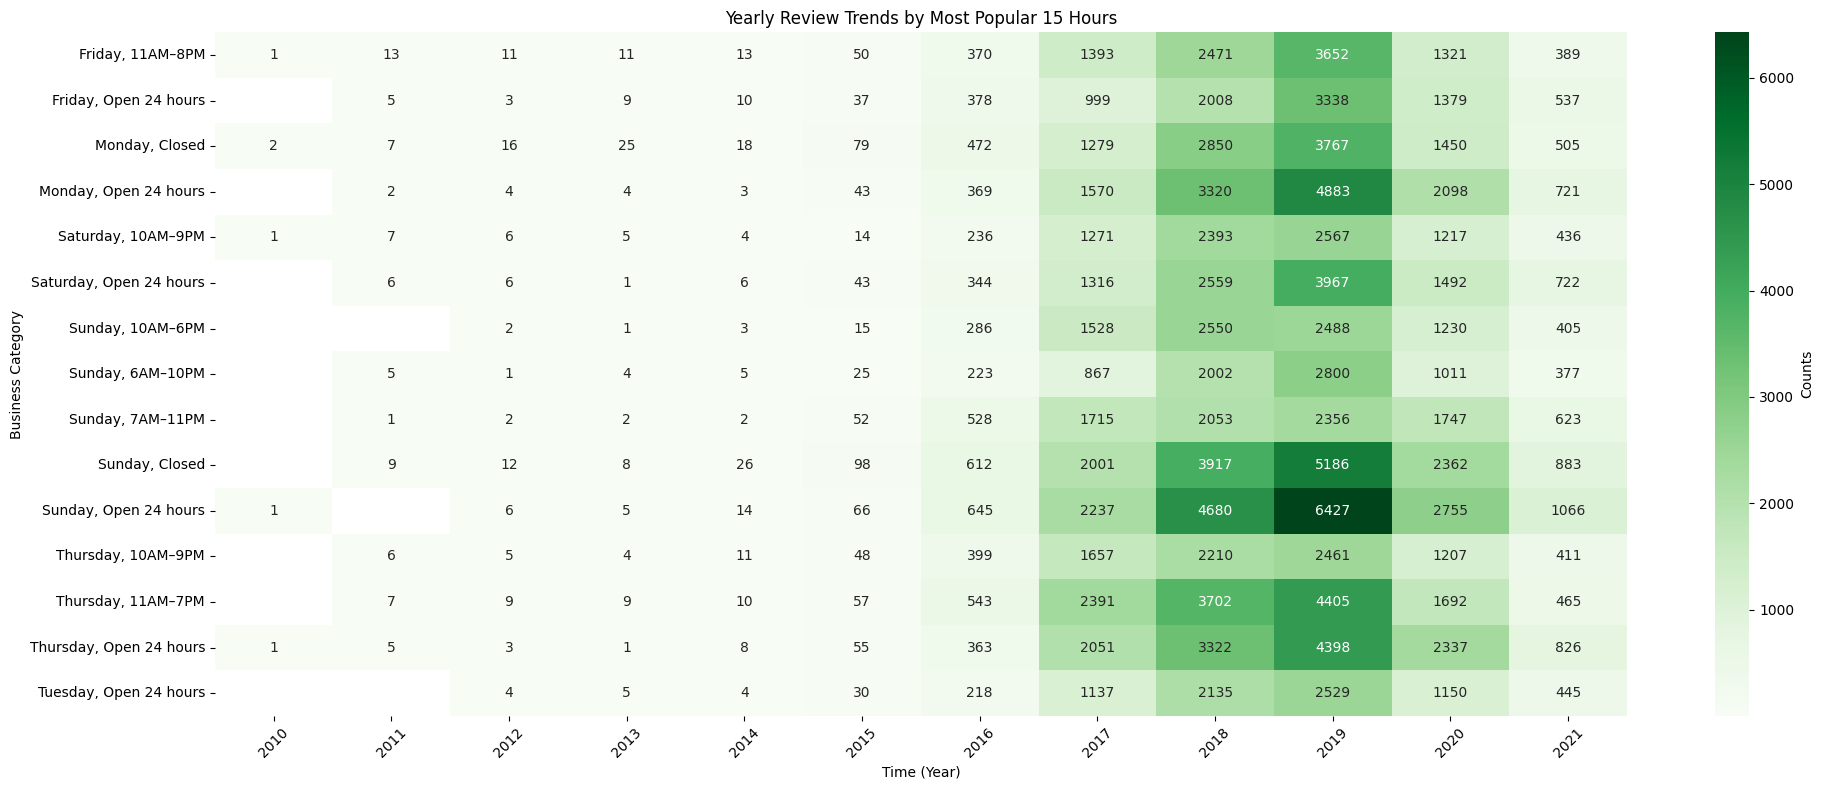

In [144]:
NUM_POP = 15
merged_clean['hours'] = merged_clean['hours'].apply(lambda x: ', '.join(x[0]) if isinstance(x, list) else x)

popular_categories = merged_clean.groupby('hours')['rating'].sum().sort_values(ascending=False).head(NUM_POP).index
filtered_df = merged_clean[merged_clean['hours'].isin(popular_categories)]

review_trends_popular = filtered_df.groupby([filtered_df['review_time(unix)'].dt.to_period('Y'), 'hours'])['rating'].count().unstack()

plt.figure(figsize=(20, 8))
sns.heatmap(review_trends_popular.T, cmap="Greens", annot=True, fmt="g", cbar_kws={'label': 'Counts'})
plt.title(f'Yearly Review Trends by Most Popular {NUM_POP} Hours')
plt.xlabel('Time (Year)')
plt.ylabel('Business Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Temporal Trend For Top Popular Business

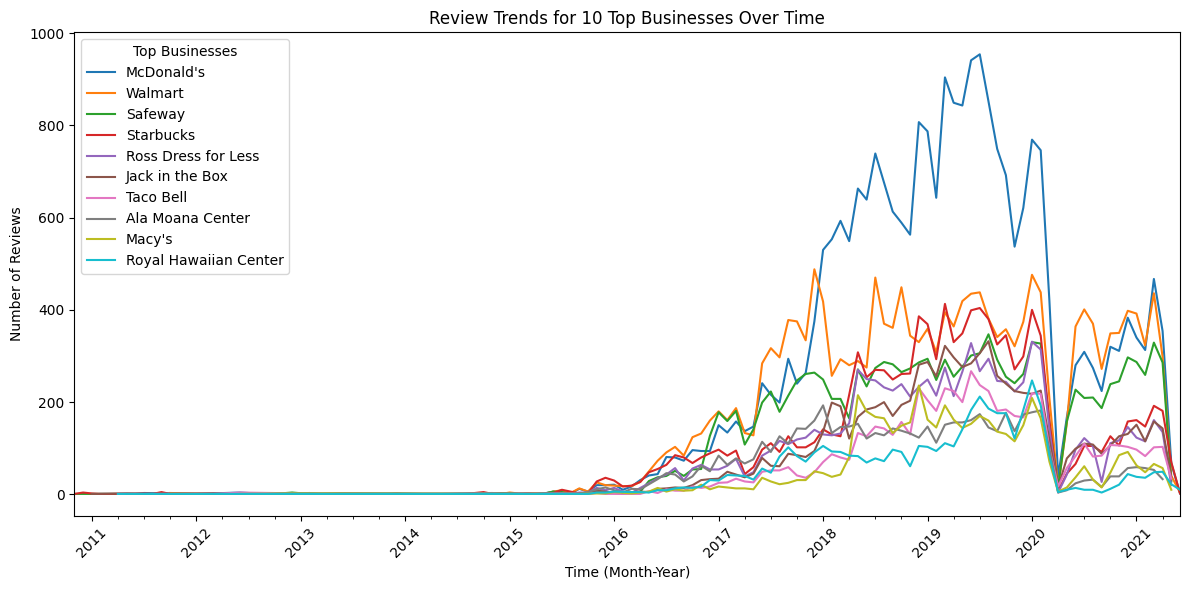

In [113]:
# Get the top 5 businesses by review count
TOP_BUSINESS_NUM = 10
top_businesses = merged_clean['gmap_name'].value_counts().head(TOP_BUSINESS_NUM).index

plt.figure(figsize=(12, 6))
for business in top_businesses:
    business_reviews = merged_clean[merged_clean['gmap_name'] == business].groupby(
        merged_clean['review_time(unix)'].dt.to_period('M')
    ).size()
    business_reviews.plot(label=business)

plt.title(f'Review Trends for {TOP_BUSINESS_NUM} Top Businesses Over Time')
plt.xlabel('Time (Month-Year)')
plt.ylabel('Number of Reviews')
plt.legend(title="Top Businesses")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
